# Estimation Methods

In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import sklearn
from scipy.optimize import minimize
from scipy.stats import lognorm, norm

## Intro

Often in machine learning, we're interested in creating a model that can predict things. The problem can be reformulated to be estimating a probability distribution (i.e. model) for a given dataset (i.e. source in which training data comes from). Thus, more formally, we can say this is a "**joint probability estimation problem**".

## Maximum Likelihood Estimation (MLE)

Bayesian method. We are trying to find the parameter $\theta$ to maximize the likelihood of seeing the data sample X. In other words, a best fit for the join probability of the data sample (X). $\theta$ in this case can represent both the probability distribution function and the parameters of that function.

Given that in our observations $X$ there are $n$ samples. We can reframe this total probability as a joint probability of observing $x_1...x_n$ in $X$ given the probability distribution function and parameter $\theta$: $P(X|\theta) = \underset{i = 1...n}{P}(x_i | \theta)$

### Setup

In [2]:
true_mean = 0.5
true_stddev = 1

initial_guess_mean = 10
initial_guess_std_dev = 1.5

In [3]:
def create_gaussian(sample_size, mean, stddev):
    gaussian_dist = np.random.normal(loc=mean, scale=stddev, size=sample_size)
    return gaussian_dist

## Estimate the true distribution using maximum likelihood estimation

Ok, we don't know the mean, or the standard deviation of the true distribution, so we'll start off by guessing.

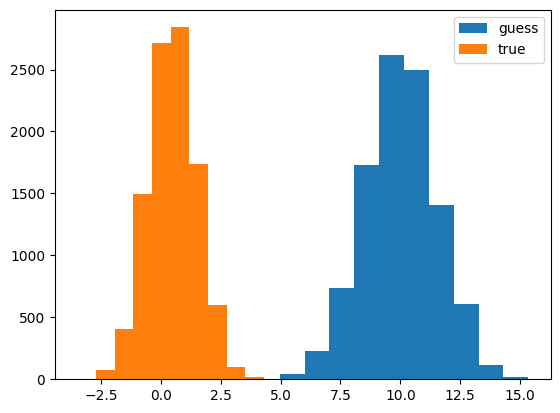

In [4]:
true_gaussian = create_gaussian(10000, true_mean, true_stddev)
guess_gaussian = create_gaussian(10000, initial_guess_mean, initial_guess_std_dev)

plt.hist(guess_gaussian, label="guess")
plt.hist(true_gaussian, label="true")
plt.legend()

We now need to use the probability density function of the normal distribution:
$$
f(x ; \mu, \sigma)=\frac{1}{\sqrt{2 \pi} \sigma} e^{-(x-\mu)^2 / 2 \sigma^2} \\
\text{where} -\infty<x<\infty
$$

In [5]:
def normal_dist_pdf(x, mu, sigma):
    import math
    # part1 = 1. / (np.sqrt(2.*np.pi) * sigma)
    # part2 = np.exp( -(x - mu)**2. / (2. * sigma ** 2) )

    # y_hat = part1 * part2
    # return y_hat
    return (
        1.0
        / (math.sqrt(2.0 * math.pi) * sigma)
        * np.exp(-np.power((x - mu) / sigma, 2.0) / 2)
    )


normal_dist_pdf(1, true_mean, true_stddev)

np.float64(0.3520653267642995)

To verify that our PDF is correct defined, let's randomly pick some x's and plot out the corresponding y's

(array([  6.,  27., 151., 300., 503., 498., 329., 137.,  39.,  10.]),
 array([-2.82993175, -2.16587736, -1.50182296, -0.83776857, -0.17371417,
         0.49034022,  1.15439462,  1.81844901,  2.48250341,  3.1465578 ,
         3.8106122 ]),
 <BarContainer object of 10 artists>)

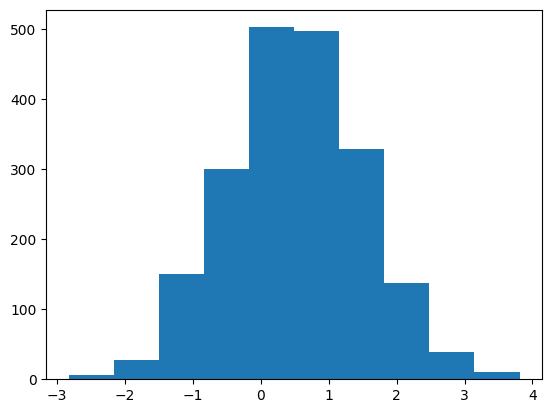

In [6]:
samples_from_true_distribution = np.random.normal(
    loc=true_mean, scale=true_stddev, size=2000
)
# samples_from_true_distribution = []
# for _ in range(2000):
#     x = normal_dist_pdf(random.uniform(-5, 5), true_mean, true_stddev)
#     samples_from_true_distribution.append(x)

plt.hist(samples_from_true_distribution)

The joint probability of the entire distribution that we're trying to estimate is just the product of all the individual probabilities of observing each example.

Since multiplying many small probabilities might lead to numeric instability, we will reframe this into the sum of log conditional probabilities of observing each example given $\sigma$ and $\mu$:
$$
l\left(\mu, \sigma^2 ; x_1, \ldots, x_n\right)=-\frac{n}{2} \ln (2 \pi)-\frac{n}{2} \ln \left(\sigma^2\right)-\frac{1}{2 \sigma^2} \sum_{j=1}^n\left(x_j-\mu\right)^2
$$

We now basically want to find the parameters ($\sigma$ and $\mu$) that maximizes this probability. In other words, the optimized parameters (weights) will eventually be very close to the true mean and standard deviation of the normal distribution we're going to predict.

In [7]:
def neg_loglikelihood(params, data):
    mu, sigma = params
    n = len(data)

    part1 = (n / 2.0) * np.log(2 * np.pi)
    part2 = (n / 2.0) * np.log(sigma**2)
    part3 = (1 / (2 * sigma**2)) * np.sum((data - mu) ** 2)
    return -(-part1 - part2 - part3)

In [8]:
optimal_result = minimize(
    fun=lambda params, data: neg_loglikelihood(params, data),
    x0=np.array([initial_guess_mean, initial_guess_std_dev]),
    args=(samples_from_true_distribution,),
    method="BFGS",
)
mu_hat, sigma_hat = optimal_result.x
print(optimal_result.success, mu_hat, sigma_hat)

False 0.5114700884762173 0.9879847250221692


### Validation

Now it's time to randomly sample from our predicted distribution to see if the plot looks the same as the ground truth distribution.

Now let's use a real dataset and we're going to try to come up with a parameterized (normal) probability distribution
that will try to predict new samples from the original dataset.


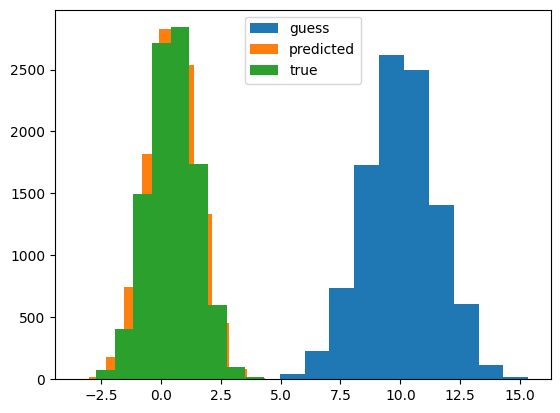

In [9]:
predicted_gaussian = create_gaussian(10000, mu_hat, sigma_hat)
plt.hist(guess_gaussian, label="guess")
plt.hist(predicted_gaussian, label="predicted")
plt.hist(true_gaussian, label="true")
plt.legend()